In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import healpy as hp
import pymaster as nmt
import pyccl as ccl
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.integrate import simps

In [2]:
def load_fits2pd(fits_file):
    cat  = Table.read(fits_file, format='fits')
    names = [name for name in cat.colnames if len(cat[name].shape) <= 1]
    catt = cat[names].to_pandas()
    return catt

def get_nz(cat):
    z_in = np.linspace(0.0, 1.5, 100) 
    nz, zz = np.histogram(cat['DNF_ZMC_SOF'], bins=100, density=None)
    zz = 0.5 * (zz[1:]+zz[:-1])
    nz_normed = nz/ simps(nz, zz)
    _p_of_z = interp1d(zz, nz_normed,bounds_error=False, fill_value=0.)
    nz_in = _p_of_z(z_in)
    return z_in, nz_in
    

In [3]:
# linear galaxy bias
bias_zs= [1.5,1.8,1.8,1.9,2.0,2.0]
# bias_zs= [1.5,1.8,1.8,1.9,1.57,1.64]
sz_zs = [0.642, 0.63 , 0.776, 0.794, 0.756, 0.896]

cosmo = ccl.Cosmology(Omega_c= 0.26, Omega_b=0.049, h=0.69 , A_s=2.19e-9, n_s=0.97,
                      matter_power_spectrum='halofit')
nside = 1024
ell = np.arange(0, 3*nside-1)
cmbl = ccl.CMBLensingTracer(cosmo, 1090.)
clkk_th  =  ccl.angular_cl(cosmo, cmbl,cmbl, ell)


# Read catalog and split the redshift bins

In [7]:
 
# data_path1 =  '/home/gabriela/Documents/Pesquisa/kxgal_new/data/data_input/raw_data/monroy/'
data_path1 = "/home/ketchup/DES_ACT_test/"
cat = load_fits2pd(data_path1+'data.fits')
cat_z1  = cat[(cat['DNF_ZMEAN_SOF']> 0.2) &(cat['DNF_ZMEAN_SOF']< 0.40) ]
print(len(cat_z1) ,' total number of galaxies' )
cat_z1.index = range(len(cat_z1))

cat_z2  = cat[(cat['DNF_ZMEAN_SOF']> 0.4) &(cat['DNF_ZMEAN_SOF']< 0.55) ]
print(len(cat_z2) ,' total number of galaxies' )
cat_z2.index = range(len(cat_z2))


cat_z3  = cat[(cat['DNF_ZMEAN_SOF']> 0.55) &(cat['DNF_ZMEAN_SOF']< 0.7) ]
print(len(cat_z3) ,' total number of galaxies' )
cat_z3.index = range(len(cat_z3))


cat_z4  = cat[(cat['DNF_ZMEAN_SOF']> 0.7) &(cat['DNF_ZMEAN_SOF']< 0.85) ]
print(len(cat_z4) ,' total number of galaxies' )
cat_z4.index = range(len(cat_z4))


cat_z5  = cat[(cat['DNF_ZMEAN_SOF']> 0.85) &(cat['DNF_ZMEAN_SOF']< 0.95) ]
print(len(cat_z5) ,' total number of galaxies' )
cat_z5.index = range(len(cat_z5))


cat_z6  = cat[(cat['DNF_ZMEAN_SOF']> 0.95) &(cat['DNF_ZMEAN_SOF']< 1.05) ]
print(len(cat_z6) ,' total number of galaxies' )
cat_z6.index = range(len(cat_z6))
catals = [cat_z1,cat_z2,cat_z3,cat_z4,cat_z5,cat_z6]

2236462  total number of galaxies
1599487  total number of galaxies


1627408  total number of galaxies
2175171  total number of galaxies


1583679  total number of galaxies
1494243  total number of galaxies


# Compute theory Cls using linear galaxy bias model, script from Gabriela 

In [8]:
des_bins = 6
cls_arr = []
clkg_arr = []

for i in range(des_bins):
  
    zz, nz = get_nz(catals[i])
    
    ccl_z1 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, bias_zs[i]*np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[i]*np.ones(len(zz)) ))
    cl_kg_th = ccl.angular_cl(cosmo, ccl_z1,cmbl, ell) #CL_k_bin

    for j in range(i, des_bins):
        
        zz, nz = get_nz(catals[j])
        ccl_z2 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, bias_zs[j]*np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[j]*np.ones(len(zz)) ))

        cl_gg_th = ccl.angular_cl(cosmo, ccl_z1,ccl_z2, ell) #CL_g1_g2
 

# Compute theory Cls using nonlinear galaxy bias model, edited by Hongbo 

In [10]:
import pyccl.nl_pt as pt
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

In [11]:
# nonlinear galaxy bias, waiting for proper fiducial values
# bias_zs = [1.5,1.8,1.8,1.9,2.0,2.0]
bias_1_zs = bias_zs
bias_2_zs = [0,0,0,0,0,0]
bias_s_zs = [0,0,0,0,0,0]

In [12]:
des_bins = 6
cls_arr = []
clkg_arr = []

for i in range(des_bins):
  
    zz, nz = get_nz(catals[i])
    
    ccl_z1 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[i]*np.ones(len(zz)) ))
    
    # consider nonlinear galaxy bias here, use PT tools
    ptt_g = pt.PTNumberCountsTracer(b1=(zz, bias_1_zs[i]*np.ones(len(zz))), b2=(zz, bias_2_zs[i]*np.ones(len(zz))), bs=(zz, bias_s_zs[i]*np.ones(len(zz))))
    ptt_m = pt.PTMatterTracer()
    
    pk_gg = pt.get_pt_pk2d(cosmo, ptt_g, ptc=ptc)
    pk_gm = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_m, ptc=ptc)

    #CL_k_bin
    cl_kg_th_nl = ccl.angular_cl(cosmo, ccl_z1, cmbl, ell, p_of_k_a=pk_gm)
    
    for j in range(i, des_bins):
        
        zz, nz = get_nz(catals[j])
        ccl_z2 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[j]*np.ones(len(zz)) ))
        #CL_g1_g2 
        cl_gg_th_nl = ccl.angular_cl(cosmo, ccl_z1,ccl_z2, ell, p_of_k_a=pk_gg) 

# Test Cls_linear and Cls_nonlinear, waiting for proper fiducial values

In [18]:
# plot scale
ellmin = 50
ellmax = 1000
ells = np.arange(ellmin, ellmax+1, 1)

<ipython-input-13-1c10f6b60fd4>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((cl_kg_th_nl/cl_kg_th)[100:])


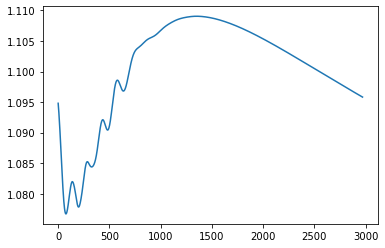

In [13]:
plt.plot(ells, (cl_kg_th_nl/cl_kg_th)[ells])

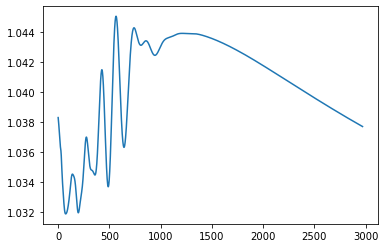

In [14]:
plt.plot((cl_gg_th_nl/cl_gg_th)[100:])